# 通过 PyTorch 构建神经网络

下面我们将了解如何使用 PyTorch 构建神经网络。

In [2]:
# Import things like usual

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

首先，我们需要获取数据集。这些数据位于 `torchvision` 软件包中。以下代码将下载 MNIST 数据集，然后为我们创建训练数据集和测试数据集。暂时不用对细节部分太关心，稍后你会详细学习的。

In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

我们将训练数据加载到了 `trainloader` 中，并使用 `iter(trainloader)`使其变成迭代器。我们将用它循环访问数据集以进行训练，但是现在我只获取了第一批数据，以便查看数据。从下方可以看出，`images` 是一个大小为 (64, 1, 28, 28) 的张量。因此，每批有 64 个图像、1 个颜色通道，共有 28x28 个图像。

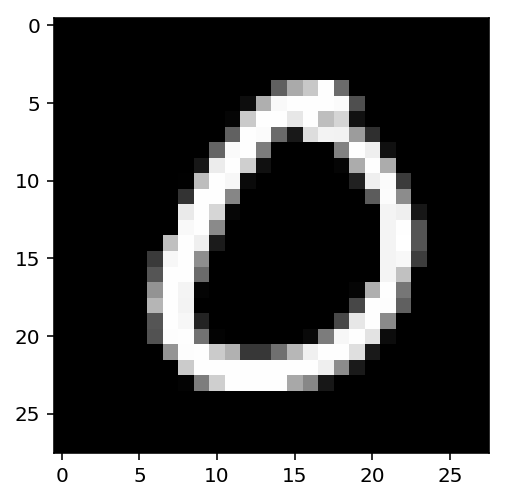

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r')

## 通过 PyTorch 构建神经网络

我将使用 PyTorch 构建一个简单的前馈网络，用于对 MNIST 图像进行分类。即该网络将接收数字图像作为输入，并预测图像中的数字。

<img src="assets/mlp_mnist.png" width=600px>

要通过 PyTorch 构建神经网络，你需要使用 `torch.nn` 模块。网络本身是继承自 `torch.nn.Module` 的类。你需要单独定义每个运算，例如针对具有 784 个输入和 128 个单元的全连接层定义为 `nn.Linear(784, 128)`。

该类需要包含对网络实现前向传递的 `forward` 方法。在此方法中，你将对之前定义的每个运算传递输入张量 `x`。`torch.nn` 模块在 `torch.nn.functional` 中还具有一些对等的功能，例如 ReLU。此模块通常导入为 `F`。要对某个层（只是一个张量）使用 ReLU 激活函数，你需要使用 `F.relu(x)`。以下是一些常见的不同激活函数。

<img src="assets/activation.png" width=700px>

对于此网络，我将添加三个全连接层，然后添加一个预测类别的 softmax 输出。softmax 函数和 S 型函数相似，都会将输入调整到 0 到 1 之间，但是还会标准化这些输入，以便所有值的和为 1，就像正常的概率分布一样。

In [6]:
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [7]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the layers, 128, 64, 10 units each
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Output layer, 10 units - one for each digit
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
    def predict(self, x):
        ''' This function for predicts classes by calculating the softmax '''
        logits = self.forward(x)
        return F.softmax(logits)

net = Network()
net

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### 初始化权重和偏差

权重等参数是系统自动初始化的，但是你也可以自定义如何初始化这些权重。权重和偏差是附加到你所定义的层的张量，你可以通过 `net.fc1.weight` 获取它们。

In [8]:
print(net.fc1.weight)
print(net.fc1.bias)

Parameter containing:
tensor([[ 2.2615e-02,  4.5731e-03,  3.2959e-02,  ...,  3.5218e-02,
          5.0738e-03, -3.5505e-02],
        [-7.9805e-03,  3.0046e-02,  2.0486e-02,  ..., -1.7375e-02,
          2.8587e-02, -1.3847e-02],
        [-5.9788e-03, -4.4190e-03,  1.8477e-02,  ...,  1.4060e-02,
          6.8474e-03,  2.2437e-03],
        ...,
        [ 2.1368e-02, -1.1702e-02,  4.1042e-03,  ..., -1.0452e-02,
         -2.3873e-03, -2.4660e-02],
        [-1.9896e-04, -6.8984e-03, -1.3804e-02,  ..., -6.7974e-03,
          3.5583e-02, -1.1624e-02],
        [-2.1139e-02, -2.9708e-02,  1.2540e-02,  ..., -3.2866e-02,
         -5.6629e-03, -5.1302e-03]])
Parameter containing:
tensor(1.00000e-02 *
       [-0.5310,  2.4105,  3.3088, -3.4897, -0.9227,  0.6930,  3.1547,
         1.9887, -1.0799,  2.5973, -2.6239,  1.2781, -2.4363,  1.1007,
        -0.5481,  2.9214, -0.2955, -0.9975, -2.4218, -0.7530, -2.7974,
         0.0691, -0.2742, -0.3181, -1.8216, -2.8132, -1.3290, -1.8023,
        -3.1891, -1

要自定义初始化过程，请原地修改这些张量。实际上存在 autograd *变量*，因此我们需要通过 `net.fc1.weight.data` 获取真正的张量。获得张量后，可以用 0（针对偏差）或随机正常值填充这些张量。

In [9]:
# Set biases to all zeros
net.fc1.bias.data.fill_(0);

In [10]:
net.fc1.bias.data

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [11]:
# sample from random normal with standard dev = 0.01
net.fc1.weight.data.normal_(std=0.01);

In [12]:
net.fc1.weight.data.shape

torch.Size([128, 784])

### 前向传递

我们已经创建好网络，看看传入图像后会发生什么。这一过程称之为前向传递。我们将图像数据转换为张量，然后传递给网络架构定义的运算。

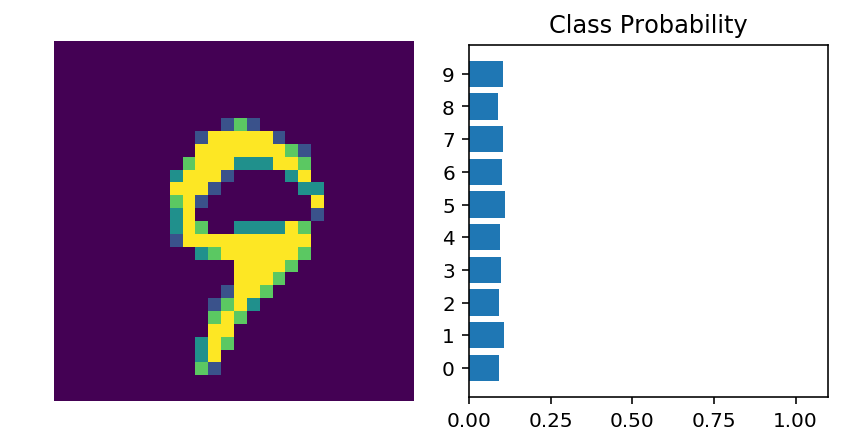

In [36]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.resize_(64, 1, 784)

# Need to wrap it in a Variable, will explain in next notebook
inputs = Variable(images) 

# Forward pass through the network
img_idx = 0
logits = net.forward(inputs[img_idx,:])

# Predict the class from the network output
ps = F.softmax(logits, dim=1)

img = images[img_idx]
helper.view_classify(img.resize_(1, 28, 28), ps)

In [38]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
display(images.shape)
display(labels.shape)
display(trainloader)
inputs.shape

torch.Size([64, 1, 28, 28])

torch.Size([64])

torch.Size([64, 1, 784])

从上图中可以看出，我们的网络基本上根本不知道这个数字是什么，因为我们还没训练它，所有权重都是随机的！接下来，我们将了解如何训练该网络，使其能学习如何正确地对这些数字进行分类。